<a href="https://colab.research.google.com/github/abidamer95/compvision/blob/notebooks/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the necessary libraries and set seed to ensure repeatability of the output

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision import datasets, models
import matplotlib.pyplot as plt
import time
import numpy as np
import random
from google.colab import drive
drive.mount('/content/drive')

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Perform transform function for image augmentation
*   Image augmentation is done based on the visualized image
*   Horizontal and vertical flip is added as some of the images has almost similar orientation
*   Rotation is added to give variation in flower position in the image
*   Colorjitter is used due to most of the image has almost the same level of brightness and contrast. This to add color variation the dataset





In [ ]:
train_transforms = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.2),
    v2.RandomRotation(degrees=15),
    v2.ColorJitter(brightness=0.4, contrast=0.4),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_transforms = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Load dataset and split into train, val and test

In [ ]:
#Load Datasets
train_data = datasets.Flowers102(root='./data', split='train', download=True, transform=train_transforms)
val_data = datasets.Flowers102(root='./data', split='val', download=True, transform=test_transforms)
test_data = datasets.Flowers102(root='./data', split='test', download=True, transform=test_transforms)

#Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

Load pre-trained ResNet50 and modify classifier
*   Load model trained with imagenet dataset
*   Freeze the model paramaters to ensure it only use the trained weight except the final layer (model.fc)
*   Final layer is modify to give out the required output (102 flower classes)

ResNet50 is choosen because of its balance between accuracy and computation speed

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights='IMAGENET1K_V1')

#freeze backbone for transfer learning purposes
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 102)
)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

Train function is created to train the model


In [ ]:
def train_model(model, train_loader, val_loader, epochs=10):
    best_acc = 0.0

    for epoch in range(epochs):
        start_time = time.time()

        # ---- TRAIN ----
        model.train()
        running_loss = 0.0
        correct = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = correct / len(train_loader.dataset)

        # ---- VALIDATION ----
        model.eval()
        val_correct = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)

        epoch_time = time.time() - start_time

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Loss: {running_loss:.4f} "
              f"Train Acc: {train_acc:.4f} "
              f"Val Acc: {val_acc:.4f} "
              f"Time: {epoch_time:.1f}s")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "/content/drive/MyDrive/models/best_resnet50_flowers.pth")

    print("Training complete. Best Val Acc:", best_acc)


First transfer learning from pre-trained ResNet50
Result: 50% accuracy in validating image
*   The result is expected due to current training weight is used for classify variation of objects
*   Fine tuning of the freeze parameters is required



In [ ]:
train_model(model, train_loader, val_loader, epochs=10)

Epoch [1/10] Loss: 152.5218 Train Acc: 0.0127 Val Acc: 0.0431 Time: 14.4s
Epoch [2/10] Loss: 145.2944 Train Acc: 0.0265 Val Acc: 0.0755 Time: 16.3s
Epoch [3/10] Loss: 141.5910 Train Acc: 0.0529 Val Acc: 0.0775 Time: 15.9s
Epoch [4/10] Loss: 134.2954 Train Acc: 0.0853 Val Acc: 0.2049 Time: 14.8s
Epoch [5/10] Loss: 126.6716 Train Acc: 0.1020 Val Acc: 0.3108 Time: 14.8s
Epoch [6/10] Loss: 119.3807 Train Acc: 0.1363 Val Acc: 0.3951 Time: 14.9s
Epoch [7/10] Loss: 112.0011 Train Acc: 0.1627 Val Acc: 0.4578 Time: 15.2s
Epoch [8/10] Loss: 105.0119 Train Acc: 0.2049 Val Acc: 0.4676 Time: 15.0s
Epoch [9/10] Loss: 98.4659 Train Acc: 0.2373 Val Acc: 0.4922 Time: 14.9s
Epoch [10/10] Loss: 95.8725 Train Acc: 0.2480 Val Acc: 0.4990 Time: 14.9s
Training complete. Best Val Acc: 0.49901960784313726


Fine tuning the model
*   Layer4 is unfreeze for fine tuning because of its layer that is closer to the final layer avoiding messing up the previous layer weight




In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/models/best_resnet50_flowers.pth"))
model = model.to(device)

# Keep earlier layers frozen
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer4 (top block)
for param in model.layer4.parameters():
    param.requires_grad = True

# Ensure classifier is trainable
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4)



Run fine-tuning

In [ ]:
train_model(model, train_loader, val_loader, epochs=10)

Epoch [1/10] Loss: 86.9716 Train Acc: 0.3039 Val Acc: 0.5980 Time: 14.7s
Epoch [2/10] Loss: 75.9703 Train Acc: 0.3735 Val Acc: 0.6196 Time: 16.1s
Epoch [3/10] Loss: 67.4220 Train Acc: 0.4353 Val Acc: 0.6892 Time: 15.6s
Epoch [4/10] Loss: 61.0891 Train Acc: 0.4755 Val Acc: 0.7078 Time: 15.9s
Epoch [5/10] Loss: 55.3327 Train Acc: 0.5343 Val Acc: 0.7471 Time: 16.4s
Epoch [6/10] Loss: 52.7493 Train Acc: 0.5441 Val Acc: 0.7696 Time: 16.8s
Epoch [7/10] Loss: 46.8771 Train Acc: 0.5833 Val Acc: 0.7873 Time: 15.7s
Epoch [8/10] Loss: 46.1192 Train Acc: 0.5843 Val Acc: 0.8010 Time: 15.7s
Epoch [9/10] Loss: 40.9710 Train Acc: 0.6441 Val Acc: 0.8039 Time: 15.5s
Epoch [10/10] Loss: 38.5069 Train Acc: 0.6627 Val Acc: 0.8392 Time: 15.9s
Training complete. Best Val Acc: 0.8392156862745098


Test accuracy of the model after transfer learning and fine tuning

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/models/best_resnet50_flowers.pth"))
model.eval()

correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        correct += (outputs.argmax(1) == labels).sum().item()

test_acc = correct / len(test_loader.dataset)
print("Test Accuracy:", test_acc)


Test Accuracy: 0.8041958041958042


In [ ]:
flower_names = ['pink primrose',
                'hard-leaved pocket orchid',
                'canterbury bells',
                'sweet pea',
                'english marigold',
                'tiger lily',
                'moon orchid',
                'bird of paradise',
                'monkshood',
                'globe thistle',
                'snapdragon',
                "colt's foot",
                'king protea',
                'spear thistle',
                'yellow iris',
                'globe-flower',
                'purple coneflower',
                'peruvian lily',
                'balloon flower',
                'giant white arum lily',
                'fire lily',
                'pincushion flower',
                'fritillary',
                'red ginger',
                'grape hyacinth',
                'corn poppy',
                'prince of wales feathers',
                'stemless gentian',
                'artichoke',
                'sweet william',
                'carnation',
                'garden phlox',
                'love in the mist',
                'mexican aster',
                'alpine sea holly',
                'ruby-lipped cattleya',
                'cape flower',
                'great masterwort',
                'siam tulip',
                'lenten rose',
                'barbeton daisy',
                'daffodil',
                'sword lily',
                'poinsettia',
                'bolero deep blue',
                'wallflower',
                'marigold',
                'buttercup',
                'oxeye daisy',
                'common dandelion',
                'petunia',
                'wild pansy',
                'primula',
                'sunflower',
                'pelargonium',
                'bishop of llandaff',
                'gaura',
                'geranium',
                'orange dahlia',
                'pink-yellow dahlia?',
                'cautleya spicata',
                'japanese anemone',
                'black-eyed susan',
                'silverbush',
                'californian poppy',
                'osteospermum',
                'spring crocus',
                'bearded iris',
                'windflower',
                'tree poppy',
                'gazania',
                'azalea',
                'water lily',
                'rose',
                'thorn apple',
                'morning glory',
                'passion flower',
                'lotus',
                'toad lily',
                'anthurium',
                'frangipani',
                'clematis',
                'hibiscus',
                'columbine',
                'desert-rose',
                'tree mallow',
                'magnolia',
                'cyclamen ',
                'watercress',
                'canna lily',
                'hippeastrum ',
                'bee balm',
                'ball moss',
                'foxglove',
                'bougainvillea',
                'camellia',
                'mallow',
                'mexican petunia',
                'bromelia',
                'blanket flower',
                'trumpet creeper',
                'blackberry lily']

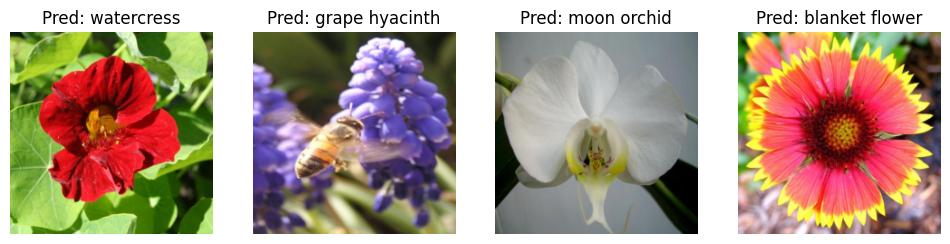

In [ ]:
# Function to show image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Un-normalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title: plt.title(title)

# --- Sample random indices from the test dataset ---
num_samples = 4  # or any number you like
indices = random.sample(range(len(test_loader.dataset)), num_samples)

plt.figure(figsize=(12, 8))

for j, idx in enumerate(indices):
    # Get the image and label from dataset
    image, label = test_loader.dataset[idx]

    # Add batch dimension and move to device
    image_input = image.unsqueeze(0).to(device)

    # Predict
    output = model(image_input)
    _, pred = torch.max(output, 1)

    # Plot
    ax = plt.subplot(1, num_samples, j + 1)
    ax.axis('off')
    name = flower_names[pred.item()]
    imshow(image.cpu(), title=f'Pred: {name}')
